<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Community-Detection-for-Hypergraph-Networks-via-Regularized-Tensor-Power-Iteration" data-toc-modified-id="Community-Detection-for-Hypergraph-Networks-via-Regularized-Tensor-Power-Iteration-1">Community Detection for Hypergraph Networks via Regularized Tensor Power Iteration</a></span><ul class="toc-item"><li><span><a href="#Packages-Required" data-toc-modified-id="Packages-Required-1.1">Packages Required</a></span></li><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-1.2">Helper Functions</a></span></li><li><span><a href="#Tensor-SCORE" data-toc-modified-id="Tensor-SCORE-1.3">Tensor-SCORE</a></span></li><li><span><a href="#Other-Methods" data-toc-modified-id="Other-Methods-1.4">Other Methods</a></span><ul class="toc-item"><li><span><a href="#HOSVD" data-toc-modified-id="HOSVD-1.4.1">HOSVD</a></span></li><li><span><a href="#Projection-to-graph" data-toc-modified-id="Projection-to-graph-1.4.2">Projection-to-graph</a></span></li><li><span><a href="#NHCut" data-toc-modified-id="NHCut-1.4.3">NHCut</a></span></li></ul></li><li><span><a href="#Numerical-Experiment" data-toc-modified-id="Numerical-Experiment-1.5">Numerical Experiment</a></span><ul class="toc-item"><li><span><a href="#Dataset-1:-Legislator-Network" data-toc-modified-id="Dataset-1:-Legislator-Network-1.5.1">Dataset 1: Legislator Network</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.5.1.1">Load Data</a></span></li><li><span><a href="#Tensor-SCORE" data-toc-modified-id="Tensor-SCORE-1.5.1.2">Tensor-SCORE</a></span></li><li><span><a href="#Other-Methods" data-toc-modified-id="Other-Methods-1.5.1.3">Other Methods</a></span></li></ul></li><li><span><a href="#Dataset-2:-Disease-Network" data-toc-modified-id="Dataset-2:-Disease-Network-1.5.2">Dataset 2: Disease Network</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.5.2.1">Load Data</a></span></li><li><span><a href="#Tensor-SCORE" data-toc-modified-id="Tensor-SCORE-1.5.2.2">Tensor-SCORE</a></span></li><li><span><a href="#Other-Methods" data-toc-modified-id="Other-Methods-1.5.2.3">Other Methods</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Community Detection for Hypergraph Networks via Regularized Tensor Power Iteration

## Packages Required

In [1]:
import numpy as np
import pandas as pd
import random
from collections import Counter
import scipy.sparse as ssp
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
from numpy.linalg import qr
from multiprocessing import Pool, cpu_count
from functools import partial, reduce
from sklearn.manifold import TSNE,MDS
import sklearn.cluster as skcluster
from itertools import permutations, combinations, combinations_with_replacement 
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix
from scipy.special import comb
from itertools import groupby

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
from numba import guvectorize
from numba import int64,float64
from numba import cuda

## Helper Functions

In [4]:
def get_nodes(x,G):
    # G: an edge-by-node incidence matrix
    # x: index of an edge
    # Return: 
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: an edge-by-node incidence matrix
    with Pool(cpu_count()-1) as pool:
        E=Counter(pool.map(partial(get_nodes,G=G), (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    return E

def get_incidence(edges):
    indices=[]
    indptr=[0]
    for e in edges:
        indptr.append(indptr[-1]+len(e))
        indices+=list(e)
    return ssp.csr_matrix((np.ones(indptr[-1]), indices, indptr))

def load_edges(filename, sep='\t', attributes=False):
    df=pd.read_csv(filename,sep)
    data=df[['edge_id','node_id']]
    G=ssp.csr_matrix((np.ones(len(data)),zip(*data.values)),shape=data.max().values+1)
    if attributes:
        df=df[[i for i in df.columns if i!='node_id']]
        df=df.drop_duplicates()
        return G,df
    else:
        return G
    
def kmeans(X, K):
    labels = skcluster.KMeans(n_clusters=K).fit(X) 
    return labels.labels_
      
def assess_error(predicted_labels,true_labels,verbose=True):
    x=contingency_matrix(true_labels,predicted_labels)
    y=[np.trace(x[i,:]) for i in permutations(range(x.shape[0]))]
    err=N-np.max(y)
    if verbose:
        print("Error {}/{}={:.2f}%".format(err,N,err/N*100))
    else:
        return err

## Tensor-SCORE

Given a hypergraph, Tensor-SCORE fits the SBM to data and infers the community membership of nodes.
1. Get initial factor matrix $U=[u_1,\cdots,u_K]$ from methods such as projection-to-graph, HOSVD, NHCut, etc.
2. Higher-order orthogonal iteration for improvements. 
    1. Compute $$C[i_1, g_2, \cdots, g_m]=\sum_{i_2,\cdots,i_m} A[i_1,i_2,\cdots,i_m] U[i_2,g_2] \cdots U[i_m,g_m], 1\leq i_1,\cdots,i_m \leq N, 1\leq g_2, \cdots, g_m \leq K.$$
    2. Calculate the QR factorization of $C^{(1)}\cdot C^{(1)T}U$, where $C^{(1)}$ is the mode-1 matrization of $C$, and update $U=Q$. (See Regalia 2013 for details.) For even modest $m$ or $K$, $C^{(1)}$ will be very wide ($K^{m-1}$ columns), and computation needs to be arranged smartly to avoiding constructing the full $C^{(1)}$.
        1. Note that many columns of $C^{(1)}$ are repeated. The unique columns correpond to the outcomes of sampling $m-1$ elements from {1,2,...,K} with replacement. Each column $(g_2, \cdots, g_m)$ is repeated ($m-1$ choose $x_1$)*($m-1-x_1$ choose $x_2$)$\cdot\cdot\cdot$($m-1-x_1-...-x_{K-1}$ choose $x_K$), where $x_k$ is the number of elements equal to $k$. (Complexity: $K+m-2$ choose $m-1$.)
        2. For each column $(g_2, \cdots, g_m)$, go over all the hyperedges. For each hyperedge $e$ and each node $v\in e$, this hyperedge contributes $\sum_{(i_2,\cdots,i_m)\in \pi(e/v)} U[i_2,g_2] \cdots U[i_m,g_m]$ to the $v$-th row of this column. (Complexity: $Mm(m-1)!$.)
        3. Calculate the QR factorization of $C^{(1)}\cdot C^{(1)T}\cdot U$. We can reorder the columns of $C^{(1)}$ and rewrite it as $[C_1,C_2,...,C_2,C_3,...,C_3...]$ where $C_i$ consists of a subset of the unique columns and it appears for as many times as its columns are repeated. Then $C^{(1)}\cdot C^{(1)T}=\sum_i r_iC_iC_i^T$ where $r_i$ is the number of times $C_i$ is repeated. (Complexity: $N^2(K+m-2$ choose $m-1)$.)
    3. Repeat all steps above until convergence.
3. Compute $b_i=u_{i+1}/u_1$, $i=1,\cdots,K-1$.
4. Partition the rows of the matrix $[b_1,\cdots,b_{K-1}]$ with any clustering algorithm, e.g., k-means.

In [5]:
MAX_EDGE=10 # The largest edge allowed. This is needed for pre-allocation.

In [6]:
@guvectorize([(int64[:],int64[:,:],float64[:,:],int64[:,:],float64[:])], '(m1),(M,m),(N,K),(p,m1)->(N)',target='cuda')
def hooi_matrization_gpu(km, T, U, permute, res):
    m=T.shape[1]
    for i in range(len(res)):
        res[i]=0
    for i in range(T.shape[0]):
        for j in range(m):
            im=cuda.local.array(MAX_EDGE,int64)
            k=0
            for l in range(m):
                if l!=j:
                    im[k]=T[i,l]
                    k+=1
            for p in range(permute.shape[0]):
                prod=1.0
                for k in range(m-1):
                    prod*=U[im[permute[p,k]],km[k]]
                res[T[i,j]]+=prod

def comb2(e):
    c=Counter(e)
    res=1
    a=len(e)
    for v in c.values():
        res*=comb(a,v)
        a=a-v
    return int(res)

def hooi_gpu(N, K, edges, U0, iterations=1, delta=0.9, diagnose=True, return_lik=False):
    m=len(edges[0])
    U_prev=U0.copy()
    permute=np.array(list(permutations(range(m-1))))
    permute=cuda.to_device(permute)
    T=cuda.to_device(np.array(edges, dtype=np.int64))
    lik=[]
    cols=sorted(combinations_with_replacement(range(K), m-1), key=comb2)
    for iteration in range(iterations):
        A=np.zeros([N,N])
        norm=np.linalg.norm(U_prev, axis=1)
        indx=norm>delta
        U_prev[indx,:]=U_prev[indx,:]/norm[indx,np.newaxis]*delta
        for k,sub_cols in groupby(cols,comb2):
            T2=hooi_matrization_gpu(list(sub_cols),T,U_prev,permute)
            T2=T2.copy_to_host()
            A+=k*T2.T.dot(T2)
        fit=np.trace(A)
        A=2*N*A.dot(U_prev)
        U_new,_=qr(A)
        lik.append(fit)
        if diagnose:
            print("Iteration: {}, Fit: {}, Difference: {}".format(iteration,fit,np.linalg.norm(abs(U_new)-abs(U_prev))), flush=True)
        U_prev=U_new
    if return_lik:
        return U_new, lik
    return U_new

If the hypergraph is not uniform (not all the hyperedges are of the same size), make all the hyperedges the same size by adding dummy nodes.

In [7]:
# Edges smaller than m will get dummy nodes, and edges larger than m will be projected to edges of size m.
def homogenize(N,m,edges,max_size=None):
    # N: number of nodes.
    # m: target uniform edge size.
    # edges: input hyperedges.
    # max_size: edges larger than max_size will be ignored. 
    if max_size is None:
        max_size=m
    min_size=m
    for e in edges:
        if (len(e)!=1 and len(e)<min_size):
            min_size=len(e)
    dummies=np.ones(m-min_size)*N + np.arange(m-min_size)
    dummies=tuple(dummies.astype(int))
    newedges=set()
    for e in edges:
        if len(e)<=1 or len(e)>max_size:
            continue
        if len(e)>m:
            for i in combinations(e,m):
                newedges.add(i)
        elif len(e)==m:
            newedges.add(e)
        else:
            newedges.add(e+dummies[len(e)-min_size:])
    return len(dummies), list(newedges)

## Other Methods

### HOSVD

In [8]:
def count(x):
    return Counter([tuple(i) for i in x])

def preduce(A):
    chunks=cpu_count()-1
    with Pool(chunks) as pool:
        res=pool.map(count, np.array_split(A,chunks,axis=0))
    return reduce(lambda x,y:x+y, res)

@guvectorize([(int64[:],int64[:,:],int64[:])], '(N),(M,m)->(N)',target='cuda')
def hosvd_matrization_gpu(pair,T,res):
    i=pair[0]
    j=pair[1]
    for k in range(len(res)):
        res[k]=-1
    end=T.shape[1]
    indxi=0
    indxj=0
    ei=T[i,:]
    ej=T[j,:]
    overlap=cuda.local.array(MAX_EDGE,int64)
    v=0
    for k in range(end):
        overlap[k]=-1
        v+=k
    csame=0
    while indxi<end and indxj<end:
        if ei[indxi]==ej[indxj]:
            overlap[indxi]=indxj
            csame+=1
            indxi+=1
            indxj+=1
        elif ei[indxi]>ej[indxj]:
            indxj+=1
        else:
            indxi+=1
    if csame==(end-1):
        for k in range(end):
            if overlap[k]==-1:
                u=ei[k]
            else:
                v-=overlap[k]
        v=ej[v]
        if u<v:
            res[0]=u
            res[1]=v
        else:
            res[0]=v
            res[1]=u

def hosvd_gpu(N,K,hyperedges,v0=None,eigs=False):
    M=len(hyperedges)
    m=len(hyperedges[0])
    T=cuda.to_device(np.array(hyperedges, dtype=np.int64))
    indices=hosvd_matrization_gpu(list(combinations(range(M),2)),T)
    indices=indices.copy_to_host()
    indices=preduce(indices)
    del indices[(-1,-1)]
    
    H=ssp.coo_matrix((list(indices.values()),zip(*(indices.keys()))),shape=(N,N),dtype=float)
    H=H+H.T
    _,U=eigsh(H,K,v0=v0)
    if eigs:
        return U
    row_norms=np.sqrt((U**2).sum(axis=1))
    B=U/row_norms.reshape(len(row_norms),1)
    return B

### Projection-to-graph

In [9]:
def score(G,K,eigs=False,project='binary'):
    if project not in ['binary', 'sum', 'normalized']:
        raise ValueError("Invalid projection type.")
    if project=='normalized':
        d=G.sum(axis=1).A.flatten()
        D=ssp.diags(1/d)
        A=G.T*D*D*G
    else:
        A=G.T*G    
    if project is 'binary':
        A.data=np.ones_like(A.data)
    _,U=eigsh(A,K)
    if eigs:
        return U
    row_norms=np.sqrt((U**2).sum(axis=1))
    B=U/row_norms.reshape(len(row_norms),1)
    return B

### NHCut

In [10]:
def NHCut(H,K,eigs=False):
    N=H.shape[1]
    d=H.sum(axis=0).A.ravel()
    D=ssp.diags(1/np.sqrt(d))
    de=H.sum(axis=1).A.ravel()
    De=ssp.diags(1/de)
    L=ssp.eye(N)-D*(H.T*De*H)*D

    _,X=eigsh(L,K,which='SA')
    if eigs:
        return X
    row_norms=np.sqrt((X**2).sum(axis=1))
    X=X/row_norms.reshape(len(row_norms),1)
    
    return X

## Numerical Experiment

### Dataset 1: Legislator Network

* Node: congressman of Peru.
* Edge: a bill proposed in the congress of Peru.

#### Load Data

In [38]:
# Load edges
G=load_edges('legislator_edges.tsv')
N=G.shape[1]
G

<589x120 sparse matrix of type '<class 'numpy.float64'>'
	with 4720 stored elements in Compressed Sparse Row format>

In [39]:
# Edge size distribution
edges=get_hyperedges(G)
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 2), (3, 1), (4, 1), (6, 185), (7, 153), (8, 96), (9, 48), (10, 33), (11, 20), (12, 14), (13, 11), (14, 5), (15, 7), (16, 3), (17, 1), (18, 2), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (65, 1)]


In [40]:
# Add dummy nodes to make all edges of size $m$
m=8
dummies,regular_edges=homogenize(N,m,edges,m)
print("Number of edges: {}".format(len(regular_edges)))

Number of edges: 438


In [41]:
# Load ground truth of nodes' communities
nodes=pd.read_csv('legislator_nodes.tsv',sep='\t')
comm=np.zeros(len(nodes),dtype=int)
comm[nodes['node_id']]=nodes['party_id']
Counter(comm)

Counter({6: 45, 2: 35, 3: 18, 0: 13, 4: 2, 1: 5, 5: 2})

In [42]:
# Number of communities
K=7 

#### Tensor-SCORE

In [43]:
U0 = hosvd_gpu(N+dummies,K,regular_edges,eigs=True)
U0[:N,:]=NHCut(G,K,eigs=True)

U,lik=hooi_gpu(N+dummies, K, regular_edges, U0, delta=10, iterations=10, diagnose=True, return_lik=True)

Iteration: 0, Fit: 62339.693256041486, Difference: 2.9697842814131334
Iteration: 1, Fit: 50013.02007697287, Difference: 1.3139523833462845
Iteration: 2, Fit: 52337.01639451497, Difference: 0.5819965311711065
Iteration: 3, Fit: 52609.406201153695, Difference: 0.5410297123978861
Iteration: 4, Fit: 52798.4426865467, Difference: 0.44715635492980366
Iteration: 5, Fit: 52968.38744872397, Difference: 0.33737475504789555
Iteration: 6, Fit: 53143.899943136224, Difference: 0.27345669714120224
Iteration: 7, Fit: 53306.26092841636, Difference: 0.23928744690555911
Iteration: 8, Fit: 53416.91311843702, Difference: 0.21870385896571035
Iteration: 9, Fit: 53482.15320753653, Difference: 0.20635032829186217


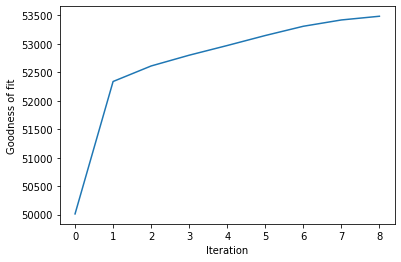

In [44]:
plt.plot(lik[1:]);
plt.xlabel('Iteration');
plt.ylabel('Goodness of fit');

In [46]:
x=U[:N,0].copy()
# Avoid divide-by-0 error
x[x==0]=1
B = U[:N,1:]/x.reshape(N,1)
T=N
norm=np.linalg.norm(B, axis=1)
indx=norm>T
B[indx,:]=B[indx,:]/norm[indx,np.newaxis]*T
labels = kmeans(B, K)
assess_error(labels, comm)

Error 17/120=14.17%


#### Other Methods

In [47]:
B=NHCut(G, K)
labels = kmeans(B, K)
assess_error(labels, comm)

Error 27/120=22.50%


In [48]:
B=score(G,K)
labels = kmeans(B, K)
assess_error(labels, comm)

Error 41/120=34.17%


In [49]:
B=score(G,K,project='sum')
labels = kmeans(B, K)
assess_error(labels, comm)

Error 41/120=34.17%


In [50]:
B=hosvd_gpu(N+dummies,K,regular_edges)
labels = kmeans(B[:N,:], K)
assess_error(labels, comm)

Error 83/120=69.17%


### Dataset 2: Disease Network

* Node: a disease (MeSH term)
* Edge: a paper annotated with the MeSH terms

#### Load Data

In [51]:
# Load edges
G=load_edges('medline_edges.tsv')
N=G.shape[1]
G

<870x190 sparse matrix of type '<class 'numpy.float64'>'
	with 1929 stored elements in Compressed Sparse Row format>

In [52]:
# Edge size distribution
edges=get_hyperedges(G)
print("Distribution of edge sizes:")
print(sorted(Counter([len(i) for i in edges]).items()))

Distribution of edge sizes:
[(2, 700), (3, 152), (4, 17), (5, 1)]


In [53]:
# Add dummy nodes to make all edges of size $m$
m=5
dummies,regular_edges=homogenize(N,m,edges,m)

In [54]:
# Load ground truth of nodes' communities
nodes=pd.read_csv('medline_nodes.tsv',sep='\t')
comm=pd.Categorical(nodes['type']).codes

In [55]:
Counter(comm)

Counter({0: 140, 1: 50})

In [56]:
# Number of communities is 2, but we set the order of the model to a larger number
K=6

#### Tensor-SCORE

In [57]:
U0 = hosvd_gpu(N+dummies,K,regular_edges,eigs=True)
U0[:N,:]=NHCut(G,K,eigs=True)

U,lik=hooi_gpu(N+dummies, K, regular_edges, U0, iterations=10, diagnose=True, return_lik=True)

Iteration: 0, Fit: 0.23704186914897468, Difference: 2.9943087047830432
Iteration: 1, Fit: 2440.8705921024207, Difference: 1.7531699936048433
Iteration: 2, Fit: 6847.777312734797, Difference: 1.0930117123385217
Iteration: 3, Fit: 9791.086931625376, Difference: 0.8404521706429633
Iteration: 4, Fit: 10802.005210452491, Difference: 0.6856292302703902
Iteration: 5, Fit: 11116.882026116944, Difference: 0.610425009146454
Iteration: 6, Fit: 11198.137220622699, Difference: 0.6269762483221376
Iteration: 7, Fit: 11153.885645126285, Difference: 0.7051239863648203
Iteration: 8, Fit: 11008.775704157511, Difference: 0.8059083107239499
Iteration: 9, Fit: 10882.009301946913, Difference: 0.9050274956854415


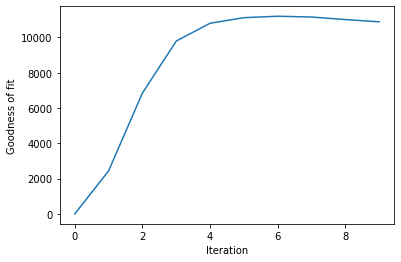

In [58]:
plt.plot(lik[:]);
plt.xlabel('Iteration');
plt.ylabel('Goodness of fit');

In [59]:
x=U[:N,0].copy()
# Avoid divide-by-0 error
x[x==0]=1
B = U[:N,1:]/x.reshape(N,1)
T=N
norm=np.linalg.norm(B, axis=1)
indx=norm>T
B[indx,:]=B[indx,:]/norm[indx,np.newaxis]*T
labels = kmeans(B, 2)
assess_error(labels, comm)

Error 7/190=3.68%


#### Other Methods

In [60]:
B=NHCut(G, K)
labels = kmeans(B, 2)
assess_error(labels, comm)

Error 55/190=28.95%


In [61]:
B=score(G,K)
labels = kmeans(B, 2)
assess_error(labels, comm)

Error 8/190=4.21%


In [62]:
B=score(G,K,project='sum')
labels = kmeans(B, 2)
assess_error(labels, comm)

Error 23/190=12.11%


In [63]:
B=hosvd_gpu(N+dummies,K,regular_edges)
labels = kmeans(B[:N,:], 2)
assess_error(labels, comm)

Error 13/190=6.84%
